<a href="https://colab.research.google.com/github/MohamedddWael/Augmented_Reality_and_Image_Mosaics/blob/main/Augmented_Reality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Augmented Reality

**This project includes the following steps:**


1. Finding correspondances between target book image and first frame in the book.mov video
2. Computing the Homography Matrix
3. Calculating book co-ordinates in the video
4. Cropping Ar video frames
5. Overlayying frames from the ar_source.mov video on the book.mov video (Augmented Reality Application)



In [17]:
#IMPORTING REQUIRED DEPENDENCIES
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
import random

### 1. Finding correspondances between target book image and first frame from the book.mov video

In [18]:
# Utility function for extracting frames from a video
def extract_frames(video_path):
  vidcap = cv2.VideoCapture(video_path)
  success,image = vidcap.read()
  frames = []
  count = 0
  while success:
    frames.append(image)
    success,image = vidcap.read()
    count += 1
  return frames

#test
#frames = extract_frames('book.mov')
#print(len(frames))
#cv2_imshow(frames[0])

In [19]:
def extract_correspondances(image1, image2, threshold= 0.75):
  sift = cv2.SIFT_create()

  # find the keypoints and descriptors with SIFT
  kp1, des1 = sift.detectAndCompute(image1,None)
  kp2, des2 = sift.detectAndCompute(image2,None)

  # BFMatcher with default params
  bf = cv2.BFMatcher()
  matches = bf.knnMatch(des1,des2,k=2)

  # Apply ratio test
  good = []
  for m,n in matches:
      if m.distance < (threshold * n.distance):
          good.append([m])
  good = random.sample(good, 50)
  return kp1, kp2, good

def draw_correspondances(img1, kp1, img2, kp2, good):
  img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
  plt.imshow(img3),plt.show()

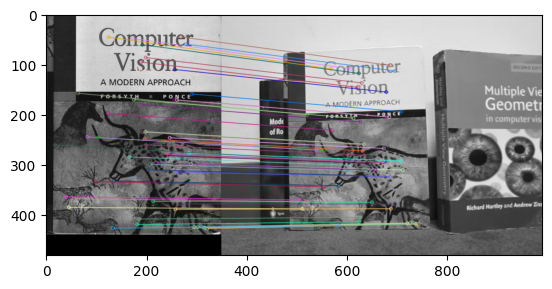

In [20]:
frames = extract_frames('book.mov')
image1 = cv2.imread('target_book.jpg', cv2.IMREAD_GRAYSCALE)
image2 = cv2.cvtColor(frames[0], cv2.COLOR_BGR2GRAY)
kp1, kp2, good = extract_correspondances(image1, image2)
draw_correspondances(image1, kp1, image2, kp2, good)

In [40]:
'''
Computing the A matrix:
Dimensions --> (2n, 8)
 '''
def compute_A(n):
  A = np.zeros((2*len(n), 9))
  for i in range(len(n)):
    x, y = n[i][0].pt
    x_prime, y_prime = n[i][1].pt
    A[2 * i, :] = np.array([-x, -y, -1 , 0 , 0, 0, x*x_prime, y*x_prime, x_prime])
    A[2*i +1, :] = np.array([0, 0, 0, -x, -y, -1, y_prime*x, y_prime*y, y_prime])
  return A

'''
computing the b matrix
Dimensions --> (2n, 1)
'''

def compute_b(n):
  b = np.zeros((2*len(n), 1))
  for i in range(len(n)):
    x_prime, y_prime = n[i][1].pt
    b[2*i] = -x_prime
    b[2*i+1] = -y_prime
  return b

In [41]:
#Function for computing the Homography Matrix
def compute_homography(n):
  assert len(n) >= 4 , "Not enough correspondances"
  A = compute_A(n)
  b = compute_b(n)
  H = np.zeros((9,1))
  H = np.dot(np.linalg.pinv(np.dot(A.T, A)), np.dot(A.T, b))
  #Normalization
  H = H/H[8]
  return H.reshape(3,3)


In [42]:
H = compute_homography(good)
print(H)

AttributeError: 'cv2.DMatch' object has no attribute 'pt'